# Models Testing on Heston data


In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

from scipy import stats

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
options_path = '../data/real_options_cleaned.csv'

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    return df

In [5]:
options_df = pd.read_csv(options_path, index_col=0)
options_df = reduce_mem_usage(options_df)

In [6]:
options_df = shuffle(options_df, random_state=0)
options_df = options_df.reset_index()
options_df['r'] = options_df['r'] / 100
options_df = options_df.drop('index', axis=1)

In [7]:
options_df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,contractSize,currency,type,expiryDate,downloadDate,close,vol,moneyness,tau,r
0,TSLA220916P00304000,2022-04-13 15:39:13,304.0,1.679688,1.419922,1.990234,-0.770020,-31.421875,1.0,153.0,...,REGULAR,USD,put,2022-09-16,2022-04-13,1022.5000,0.581055,0.297363,0.428467,0.007851
1,TSLA230915C00375000,2022-03-29 15:21:57,375.0,752.000000,503.250000,518.500000,0.000000,0.000000,4.0,4.0,...,REGULAR,USD,call,2023-09-15,2022-05-04,952.5000,0.653809,2.539062,1.371094,0.008331
2,AMD221021P00090000,2022-05-02 19:41:36,90.0,13.398438,12.898438,13.101562,-1.349609,-9.156250,30.0,4328.0,...,REGULAR,USD,put,2022-10-21,2022-05-02,89.8125,0.541504,1.001953,0.472412,0.009323
3,TSLA230120C01750000,2022-05-24 16:39:03,1750.0,5.769531,5.000000,6.101562,-1.259766,-17.921875,13.0,518.0,...,REGULAR,USD,call,2023-01-20,2022-05-24,628.0000,0.859375,0.358887,0.662109,0.010880
4,AMZN240119C03850000,2022-04-26 18:58:31,3850.0,228.500000,80.000000,98.000000,0.000000,0.000000,2.0,54.0,...,REGULAR,USD,call,2024-01-19,2022-05-05,2328.0000,0.671387,0.604492,1.713867,0.008530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636030,TSLA230915P01425000,2022-05-19 16:13:22,1425.0,734.500000,736.500000,754.500000,59.750000,8.851562,2.0,80.0,...,REGULAR,USD,put,2023-09-15,2022-05-19,709.5000,0.834473,2.007812,1.330078,0.010323
636031,TSLA220520P00580000,2022-05-04 19:53:41,580.0,0.830078,0.660156,0.859863,-1.080078,-56.531250,271.0,590.0,...,REGULAR,USD,put,2022-05-20,2022-05-04,952.5000,0.653809,0.608887,0.043945,0.008331
636032,MSFT220916C00185000,2022-05-02 17:52:36,185.0,96.625000,97.375000,100.875000,0.000000,0.000000,2.0,2600.0,...,REGULAR,USD,call,2022-09-16,2022-05-03,281.7500,0.407227,1.523438,0.373535,0.008812
636033,AMZN230317P03300000,2022-05-24 16:20:29,3300.0,1226.000000,1167.000000,1186.000000,0.000000,0.000000,17.0,107.0,...,REGULAR,USD,put,2023-03-17,2022-05-25,2136.0000,0.752930,1.544922,0.812988,0.010719


# Preprocessing

In [8]:
cols_to_drop = ['impliedVolatility',
                  'inTheMoney',
                  'change',
                  'percentChange',
                  'bid',
                  'ask',
                  'volume',
                  'openInterest',
                  'contractSymbol',
                  'lastTradeDate',
                  'contractSize',
                  'currency',
                  'expiryDate',
                  'downloadDate']
options_df = options_df.drop(cols_to_drop, axis=1)
options_df = pd.get_dummies(options_df, prefix='', prefix_sep='')

In [9]:
input_sc = StandardScaler()
output_sc = StandardScaler()
input_data = input_sc.fit_transform(options_df.drop(['lastPrice'], axis=1))
output_data = output_sc.fit_transform(options_df['lastPrice'].values.reshape(-1, 1))

train_size = 0.8
val_size = 0.1

last_train_idx = int(np.round(len(input_data) * train_size))
last_val_idx = last_train_idx + int(np.round(len(input_data) * val_size))

X_train = input_data[0:last_train_idx]
X_val = input_data[last_train_idx:last_val_idx]
X_test = input_data[last_val_idx:]

y_train = output_data[0:last_train_idx]
y_val = output_data[last_train_idx:last_val_idx]
y_test = output_data[last_val_idx:]

In [10]:
df_cols = options_df.columns
df_cols

Index(['strike', 'lastPrice', 'close', 'vol', 'moneyness', 'tau', 'r', 'call',
       'put'],
      dtype='object')

In [11]:
X_train = Variable(torch.Tensor(X_train))
X_val = Variable(torch.Tensor(X_val))
X_test = Variable(torch.Tensor(X_test))

y_train = Variable(torch.Tensor(y_train))
y_val = Variable(torch.Tensor(y_val))
y_test = Variable(torch.Tensor(y_test))

# Model

In [12]:
CUDA = torch.cuda.is_available()
device = 'cuda:0' if CUDA else 'cpu'

In [13]:
class ResBlock(nn.Module):

  def __init__(self, module):
    super(ResBlock, self).__init__()
    self.module = module

  def forward(self, x):
    return self.module(x) + x

In [14]:
class HiddenLayer(nn.Module):

  def __init__(self, layer_size, act_fn):
      super(HiddenLayer, self).__init__()
      
      if act_fn == 'ReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ReLU())
      elif act_fn == 'LeakyReLU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.LeakyReLU())
      elif act_fn == 'ELU':
        self.layer = nn.Sequential(
          nn.Linear(layer_size, layer_size),
          nn.ELU())
    
  def forward(self, x):
    return self.layer(x)

In [15]:
class Net(nn.Module):

  def __init__(self, input_size, output_size, hidden_size, num_layers, act_fn):
    super(Net, self).__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size = hidden_size

    if act_fn == 'ReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ReLU())
    elif act_fn == 'LeakyReLU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.LeakyReLU())
    elif act_fn == 'ELU':
      self.initial_layer = nn.Sequential(
          nn.Linear(self.input_size, self.hidden_size),
          nn.ELU())

    self.hidden_layers_list = []

    for i in range(num_layers // 2):
      self.hidden_layers_list.append(
          ResBlock(
            nn.Sequential(
                HiddenLayer(self.hidden_size, act_fn),
                HiddenLayer(self.hidden_size, act_fn)
            )
        )
      )

    self.hidden_layers = nn.Sequential(*self.hidden_layers_list)

    self.net = nn.Sequential(
        self.initial_layer,
        self.hidden_layers,
        nn.Linear(self.hidden_size, self.output_size)
    )
  
  def forward(self, x):
    return self.net(x)

In [16]:
def init_weights(m, init_m: str):

  @torch.no_grad()
  def init_uniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_normal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.normal_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xuniform(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  @torch.no_grad()
  def init_xnormal(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0.01)

  if init_m == 'uniform':
    m.apply(init_uniform)
  elif init_m == 'normal':
    m.apply(init_normal)
  elif init_m == 'xaiver uniform':
    m.apply(init_xuniform)
  elif init_m == 'xavier normal':
    m.apply(init_xnormal)

# Training

In [17]:
input_size = 8
output_size = 1
num_layers = 4
hidden_size = 800
batch_size = 774
epochs = 2000
lr = 5.973524887918111e-05
init_method = 'xaiver uniform'
act_fn = 'LeakyReLU'

model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
init_weights(model, init_method)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [18]:
model = model.to(device)

In [19]:
class OptDataset(Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

### Losses Metrics

In [20]:
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output) / target))

In [21]:
def evaluate(model, loss_fn, X_val, y_val):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch, batch_labels in DataLoader(OptDataset(X_val, y_val), batch_size=batch_size):
            out = model(batch.to(device))
            loss = loss_fn(out, batch_labels.to(device))
            losses.append(loss.item())

    losses = np.array(losses)
    print('\nVal set: Average loss: {:.8f}\n'.format(
                losses.mean()))
    return losses.mean()

### Early Stopping class

In [22]:
# Code took form: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, 
                 patience=10, 
                 verbose=False, 
                 delta=0, 
                 path='../models/final_heston_model.chkpt',
                 trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Train Loop

In [23]:
def train(
    epochs,
    batch_size,
    model,
    optimizer,
    loss_fn,
    X_train,
    y_train,
    X_val,
    y_val
):

  training_losses = []
  validation_losses = []

  early_stopping = EarlyStopping(patience=20)

  for epoch in range(epochs):
    model.train()
    epoch_losses = []
    total_loss = 0
    start_time = time.time()
    i = 0

    for batch, batch_labels in DataLoader(OptDataset(X_train, y_train), batch_size=batch_size):
      out = model(batch.to(device))
      optimizer.zero_grad()

      loss = loss_fn(out, batch_labels.to(device))
      epoch_losses.append(loss.item())
      total_loss += loss.item()
      loss.backward()
      optimizer.step()

      if i > 0 and i % 50 == 0:
        avg_loss = total_loss / 50
        elapsed = time.time() - start_time
        print('| Epoch {:3d} | {:5d}/{:5d} batches | lr {:2.5f} | ms/batch {:5.2f} | '
                  'loss {:5.8f}'.format(
              epoch, i, len(X_train) // batch_size+1, lr, elapsed * 1000 / 50,
              avg_loss))
        start_time = time.time()
        total_loss = 0

      i += 1

    training_losses.append(np.array(epoch_losses).mean())
    val_loss = evaluate(model, loss_fn, X_val, y_val)
    validation_losses.append(val_loss)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Stopping at Epoch: {epoch}")
        break

  return training_losses, validation_losses

In [24]:
load = False
save_model_path = '../models/final_real_data_model_cleaned.chkpt'
val_err_df_path = '../results/val_final_real_data_model_cleaned.csv'

if not load:
  train_losses, val_losses = train(
      epochs,
      batch_size,
      model,
      optimizer,
      loss_fn,
      X_train,
      y_train,
      X_val,
      y_val)
  val_err_df = pd.DataFrame({
      'Training': train_losses,
      'Validation': val_losses})
  val_err_df.to_csv(val_err_df_path)
  torch.save(model.state_dict(), save_model_path)
else:
  model = Net(input_size, output_size, hidden_size, num_layers, act_fn)
  model.load_state_dict(torch.load(save_model_path, map_location=device))
  model = model.to(device)
  val_err_df = pd.read_csv(val_err_df_path, index_col=0)

| Epoch   0 |    50/  658 batches | lr 0.00006 | ms/batch 18.03 | loss 0.56602240
| Epoch   0 |   100/  658 batches | lr 0.00006 | ms/batch 14.46 | loss 0.20456803
| Epoch   0 |   150/  658 batches | lr 0.00006 | ms/batch 12.64 | loss 0.13454285
| Epoch   0 |   200/  658 batches | lr 0.00006 | ms/batch 12.69 | loss 0.12160536
| Epoch   0 |   250/  658 batches | lr 0.00006 | ms/batch 14.17 | loss 0.11693148
| Epoch   0 |   300/  658 batches | lr 0.00006 | ms/batch 12.89 | loss 0.11221922
| Epoch   0 |   350/  658 batches | lr 0.00006 | ms/batch 15.16 | loss 0.11183932
| Epoch   0 |   400/  658 batches | lr 0.00006 | ms/batch 14.93 | loss 0.10417253
| Epoch   0 |   450/  658 batches | lr 0.00006 | ms/batch 12.68 | loss 0.10507297
| Epoch   0 |   500/  658 batches | lr 0.00006 | ms/batch 12.65 | loss 0.10926801
| Epoch   0 |   550/  658 batches | lr 0.00006 | ms/batch 14.23 | loss 0.10623062
| Epoch   0 |   600/  658 batches | lr 0.00006 | ms/batch 12.73 | loss 0.09847115
| Epoch   0 |   

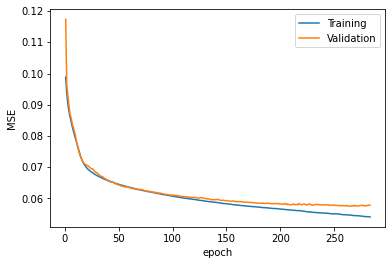

In [25]:
val_err_df[1:].plot(xlabel='epoch', ylabel='MSE')
plt.plot();

# Test the model

In [26]:
model.eval();

In [27]:
test_size = 30

with torch.no_grad():
    test_out = model(X_test[0:test_size].to(device))

test_out = output_sc.inverse_transform(test_out.cpu().detach().numpy())
real_out = output_sc.inverse_transform(y_test[0:test_size].cpu().detach().numpy())

In [28]:
cols = ['strike', 'close', 'hv_21', 'moneyness', 'tau', 'r',
       'call', 'put']
test_options = pd.DataFrame(input_sc.inverse_transform(X_test[0:test_size].detach().cpu().numpy()), columns=cols)

In [29]:
test_options['Prediction'] = test_out
test_options['Real'] = real_out
test_options

,strike,close,hv_21,moneyness,tau,r,call,put,Prediction,Real
0,724.942017,1078.057373,0.601565,0.672724,0.291270,0.005249,0.000239,0.999761,13.695415,20.074718
1,119.779816,186.636154,1.620926,0.643852,0.010965,0.010750,0.000239,0.999761,-11.851948,-0.095158
2,970.000977,952.522156,0.653796,1.018581,0.120999,0.008331,0.000239,0.999761,117.253822,152.008652
3,2159.910889,2146.113281,0.751449,0.993920,0.002666,0.010322,0.999798,0.000202,33.196011,21.010876
4,3176.765381,2890.473389,0.405984,0.910914,0.099046,0.008408,0.999798,0.000202,65.812744,53.350750
5,102.653839,169.737167,0.838465,0.604154,1.063380,0.010719,0.000239,0.999761,2.352215,12.840801
6,104.794586,197.499741,0.826699,1.882022,0.181236,0.009094,0.999798,0.000202,92.213051,97.350006
7,1559.966797,2518.695557,0.633307,1.614246,0.716814,0.008331,0.999798,0.000202,1477.562988,1360.902954
8,719.991516,193.073837,0.660636,0.267920,1.639517,0.011406,0.999798,0.000202,-5.173756,1.266521
9,249.830109,199.511520,1.524059,0.797834,0.387449,0.008408,0.999798,0.000202,13.408627,9.436596


In [30]:
test_options['Abs Error'] = np.abs(test_options.Prediction - test_options.Real)

In [31]:
test_options.sort_values('Abs Error')

,strike,close,hv_21,moneyness,tau,r,call,put,Prediction,Real,Abs Error
12,334.924774,169.737167,0.726566,0.505509,0.530279,0.009071,0.999798,0.000202,0.241360,1.777157,1.535797
16,294.785797,290.041779,0.417067,0.983093,0.871156,0.008331,0.999798,0.000202,30.297482,28.244793,2.052689
28,639.981140,172.955978,1.544856,0.270326,0.030241,0.009071,0.999798,0.000202,-2.701969,-0.095158,2.606812
17,174.904022,90.875229,0.547864,0.519945,0.085124,0.008812,0.999798,0.000202,3.242138,-0.095158,3.337296
22,1579.768677,2486.507080,0.643534,0.636033,0.123676,0.008812,0.000239,0.999761,2.528118,6.032406,3.504288
9,249.830109,199.511520,1.524059,0.797834,0.387449,0.008408,0.999798,0.000202,13.408627,9.436596,3.972031
23,569.871704,876.476685,0.712405,0.650468,0.392870,0.008331,0.000239,0.999761,24.414364,29.010738,4.596375
19,182.396637,156.459396,0.277649,1.165044,0.005343,0.008232,0.000239,0.999761,18.848461,23.819332,4.970871
6,104.794586,197.499741,0.826699,1.882022,0.181236,0.009094,0.999798,0.000202,92.213051,97.350006,5.136955
15,399.682343,156.459396,0.277649,2.554791,0.140275,0.008232,0.000239,0.999761,56.851192,51.223125,5.628067


### MSE on the test set

In [32]:
def get_mse(model, X, y, batch_size):
    losses = []
    with torch.no_grad():
        for batch, batch_labels in DataLoader(OptDataset(X, y), batch_size=batch_size):
            out = model(batch.to(device))
            loss = loss_fn(out, batch_labels.to(device))
            losses.append(loss.item())

    losses = np.array(losses)
    return losses

In [33]:
model.eval()

print('The MSE on the train set is: ', get_mse(model, X_train, y_train, batch_size).mean())
print('The MSE on the val set is: ', get_mse(model, X_val, y_val, batch_size).mean())
print('The MSE on the test set is: ', get_mse(model, X_test, y_test, batch_size).mean())

The MSE on the train set is:  0.055784855015281486
The MSE on the val set is:  0.05784665452069547
The MSE on the test set is:  0.06300446296851318


### MAE on the test set

In [34]:
def get_mae(model, X, y, batch_size):
    mae_loss = nn.L1Loss()
    losses = []
    with torch.no_grad():
        for batch, batch_labels in DataLoader(OptDataset(X, y), batch_size=batch_size):
            out = model(batch.to(device))
            loss = mae_loss(out, batch_labels.to(device))
            losses.append(loss.item())

    losses = np.array(losses)
    return losses

In [35]:
model.eval()

print('The MAE on the train set is: ', get_mae(model, X_train, y_train, batch_size).mean())
print('The MAE on the val set is: ', get_mae(model, X_val, y_val, batch_size).mean())
print('The MAE on the test set is: ', get_mae(model, X_test, y_test, batch_size).mean())

The MAE on the train set is:  0.08593935257893928
The MAE on the val set is:  0.08775011225637183
The MAE on the test set is:  0.0903486671397485


### RSME on the test set

In [36]:
model.eval()

print('The RMSE on the train set is: ', np.sqrt(get_mse(model, X_train, y_train, batch_size)).mean())
print('The RMSE on the val set is: ', np.sqrt(get_mse(model, X_val, y_val, batch_size)).mean())
print('The RMSE on the test set is: ', np.sqrt(get_mse(model, X_test, y_test, batch_size)).mean())

The RMSE on the train set is:  0.23468705471699283
The RMSE on the val set is:  0.2386931611242923
The RMSE on the test set is:  0.24977507467035934


### MAPE on the test set

In [37]:
def get_mape(model, X, y, batch_size):
    losses = []
    with torch.no_grad():
        for batch, batch_labels in DataLoader(OptDataset(X, y), batch_size=batch_size):
            out = model(batch.to(device))
            loss = MAPELoss(out, batch_labels.to(device)).detach().cpu().item()
            losses.append(loss)

    return np.array(losses)

In [38]:
model.eval()

print('The MAPE on the train set is: ', get_mape(model, X_train, y_train, batch_size).mean())
print('The MAPE on the val set is: ', get_mape(model, X_val, y_val, batch_size).mean())
print('The MAPE on the test set is: ', get_mape(model, X_test, y_test, batch_size).mean())

The MAPE on the train set is:  0.524604383369166
The MAPE on the val set is:  0.4246139897998557
The MAPE on the test set is:  0.6576548123575119


### $R^2$

In [39]:
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    out = model(X_test[0:batch_size].to(device)).squeeze().cpu().detach().numpy()

y_true = y_test[0:batch_size].cpu().squeeze().detach().numpy()

r2 = r2_score(y_pred=out, y_true=y_true)

print('the R^2 score is: ', r2)

the R^2 score is:  0.9516276514431621


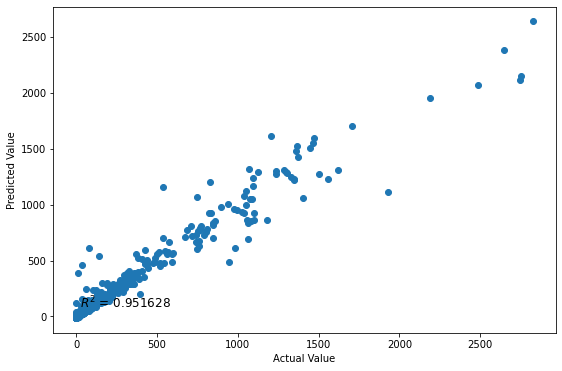

In [40]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()

ax.scatter(
    y=output_sc.inverse_transform(out.reshape(-1, 1)),
    x=output_sc.inverse_transform(y_true.squeeze().reshape(-1, 1))
)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')

ax.text(20, 80, f'$R^2$ = {np.round(r2, 6)}', fontsize=12)

plt.show()